In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle
import datetime

from utils import load_sentences_and_labels, get_normalized_sentences, \
        load_word2vec, build_token_embeddings_tensor, encode_sentences_and_labels

In [2]:
devset_sentences, devset_labels = load_sentences_and_labels('factRuEval-2016-master/devset')

testset_sentences, testset_labels = load_sentences_and_labels('factRuEval-2016-master/testset')

sentences = np.concatenate((devset_sentences, testset_sentences[:-500]), axis=0)
labels = np.concatenate((devset_labels, testset_labels[:-500]), axis=0)

#normalized_sentences = get_normalized_sentences(sentences)
#with open('devset-normalized_sentences.pk', 'wb') as normalized_sentences_dump:
#    pickle.dump(normalized_sentences, normalized_sentences_dump)

with open('train-normalized_sentences.pk', 'rb') as normalized_sentences_dump:
    normalized_sentences = pickle.load(normalized_sentences_dump)

test_sentences = testset_sentences[-500:]
test_labels = testset_labels[-500:]

#test_normalized_sentences = get_normalized_sentences(test_sentences)
#with open('test-normalized_sentences.pk', 'wb') as normalized_sentences_dump:
#    pickle.dump(test_normalized_sentences, normalized_sentences_dump)

with open('test-normalized_sentences.pk', 'rb') as normalized_sentences_dump:
    test_normalized_sentences = pickle.load(normalized_sentences_dump)

for sentence_labels in test_labels:
    for index in range(len(sentence_labels)):
        if sentence_labels[index] == 'facility_descr':
            sentence_labels[index] = 'none'

In [3]:
def get_f1(model, label_codes, encoded_symbols, encoded_tokens, encoded_labels,
           unique_labels_count):

    model.train(mode=False)

    batch_size = 100
    EPSILON = 1e-10

    f1 = 0.0

    for i in range(len(encoded_symbols)//batch_size):

        batch_indices = slice(batch_size*i, batch_size*(i + 1))

        batch_encoded_symbols = autograd.Variable(torch.LongTensor(
                encoded_symbols[batch_indices]))

        batch_encoded_tokens = autograd.Variable(torch.LongTensor(
                encoded_tokens[batch_indices]))

        batch_encoded_labels_numpy = encoded_labels[batch_indices]
        batch_labels_count = batch_encoded_labels_numpy.shape[0]*\
                batch_encoded_labels_numpy.shape[1]
        batch_encoded_labels_numpy = batch_encoded_labels_numpy.ravel()
        batch_encoded_labels = autograd.Variable(torch.LongTensor(
                batch_encoded_labels_numpy))

        predicted_label_probs = model(batch_encoded_symbols, batch_encoded_tokens).view(
                batch_labels_count, unique_labels_count)

        predicted_encoded_labels = predicted_label_probs.data.numpy().argmax(axis=1)

        relevant_mask = (batch_encoded_labels_numpy != label_codes['none'])
        selected_mask = (predicted_encoded_labels != label_codes['none'])
        relevant_and_selected_count = np.logical_and(relevant_mask, selected_mask).sum()

        recall = relevant_and_selected_count/(relevant_mask.sum() + EPSILON)
        precision = relevant_and_selected_count/(selected_mask.sum() + EPSILON)
        f1 += 2*recall*precision/(recall + precision + EPSILON)

    f1 /= len(encoded_symbols)//batch_size

    return f1

class NERTagger(nn.Module):

    def __init__(self, unique_symbols_count, unique_labels_count, token_dimension,
                 token_embeddings_tensor):

        super(NERTagger, self).__init__()

        #TODO: add residual connections

        symbol_embedding_dimension = 32
        symbol_convolution_out_channels = 64
        symbol_convolution_kernel_size = 3
        symbol_convolution_padding = 1

        unique_tokens_count, token_embedding_dimension = token_embeddings_tensor.shape

        token_convolution_out_channels = 256
        token_convolution_kernel_size = 5
        token_convolution_padding = 2

        self.symbol_embedding = nn.Embedding(unique_symbols_count,
                                             symbol_embedding_dimension)
        self.symbol_convolution = nn.Conv1d(symbol_embedding_dimension,
                                            symbol_convolution_out_channels,
                                            symbol_convolution_kernel_size,
                                            padding=symbol_convolution_padding)
        self.symbol_relu = nn.ReLU()
        self.symbol_dropout = nn.Dropout()
        self.symbol_batchnorm = nn.BatchNorm1d(symbol_convolution_out_channels)
        self.symbol_pooling = nn.MaxPool1d(token_dimension,
                                           stride=token_dimension)

        self.token_embedding = nn.Embedding(unique_tokens_count,
                                            token_embedding_dimension)
        self.token_embedding.weight = nn.Parameter(token_embeddings_tensor)

        self.token_convolution1 = nn.Conv1d(token_embedding_dimension + \
                                            symbol_convolution_out_channels,
                                            token_convolution_out_channels,
                                            token_convolution_kernel_size,
                                            padding=token_convolution_padding)
        self.token_relu1 = nn.ReLU()
        self.token_dropout1 = nn.Dropout()
        self.token_batchnorm1 = nn.BatchNorm1d(token_convolution_out_channels)

        self.token_convolution2 = nn.Conv1d(token_convolution_out_channels,
                                            token_convolution_out_channels,
                                            token_convolution_kernel_size,
                                            padding=token_convolution_padding)
        self.token_relu2 = nn.ReLU()
        self.token_dropout2 = nn.Dropout()
        self.token_batchnorm2 = nn.BatchNorm1d(token_convolution_out_channels)

        self.lstm = nn.LSTM(token_convolution_out_channels, unique_labels_count)

    def forward(self, encoded_symbols, encoded_tokens):

        symbol_embeddings = self.symbol_embedding(encoded_symbols)
        symbol_embeddings = torch.transpose(symbol_embeddings, 1, 2)
        symbol_forwarded_data = self.symbol_convolution(symbol_embeddings)
        symbol_forwarded_data = self.symbol_relu(symbol_forwarded_data)
        symbol_forwarded_data = self.symbol_dropout(symbol_forwarded_data)
        symbol_forwarded_data = self.symbol_batchnorm(symbol_forwarded_data)

        symbol_forwarded_data = self.symbol_pooling(symbol_forwarded_data)
        symbol_forwarded_data = torch.transpose(symbol_forwarded_data, 1, 2)

        token_embeddings = self.token_embedding(encoded_tokens)
        token_forwarded_data = torch.cat((symbol_forwarded_data, token_embeddings), dim=2)
        token_forwarded_data = torch.transpose(token_forwarded_data, 1, 2)

        token_forwarded_data = self.token_convolution1(token_forwarded_data)
        token_forwarded_data = self.token_relu1(token_forwarded_data)
        token_forwarded_data = self.token_dropout1(token_forwarded_data)
        token_forwarded_data = self.token_batchnorm1(token_forwarded_data)

        token_forwarded_data = self.token_convolution2(token_forwarded_data)
        token_forwarded_data = self.token_relu2(token_forwarded_data)
        token_forwarded_data = self.token_dropout2(token_forwarded_data)
        token_forwarded_data = self.token_batchnorm2(token_forwarded_data)

        result_forwarded_data = torch.transpose(token_forwarded_data, 1, 2)
        result_forwarded_data = torch.transpose(result_forwarded_data, 0, 1)
        result_forwarded_data = self.lstm(result_forwarded_data)[0]
        result_forwarded_data = torch.transpose(result_forwarded_data, 0, 1)

        result_forwarded_data = F.log_softmax(result_forwarded_data, dim=2)

        return result_forwarded_data

In [4]:
data_size = len(sentences)
train_data_size = int(data_size*0.8)
val_data_size = data_size - train_data_size

#np.random.seed(seed=1)
#data_permutation = np.random.permutation(data_size)

train_sentences = sentences[:train_data_size]
train_normalized_sentences = sentences[:train_data_size]
train_labels = labels[:train_data_size]

symbol_codes, token_codes, label_codes, sentence_dimension, token_dimension, \
        train_encoded_symbols, train_encoded_tokens, train_encoded_labels = \
        encode_sentences_and_labels(train_sentences, train_normalized_sentences,
                                    train_labels)

unique_symbols_count = len(symbol_codes)
unique_tokens_count = len(token_codes)
unique_labels_count = len(label_codes)

val_sentences = sentences[train_data_size:]
val_normalized_sentences = sentences[train_data_size:]
val_labels = labels[train_data_size:]

val_encoded_symbols, val_encoded_tokens, val_encoded_labels = \
        encode_sentences_and_labels(val_sentences, val_normalized_sentences,
        val_labels, codes=(symbol_codes, token_codes, label_codes),
        dimensions=(sentence_dimension, token_dimension))

test_encoded_symbols, test_encoded_tokens, test_encoded_labels = \
        encode_sentences_and_labels(test_sentences, test_normalized_sentences,
        test_labels, codes=(symbol_codes, token_codes, label_codes),
        dimensions=(sentence_dimension, token_dimension))

In [5]:
word2vec = load_word2vec()
token_embeddings_tensor = build_token_embeddings_tensor(token_codes, word2vec, 300)

model = NERTagger(unique_symbols_count, unique_labels_count, token_dimension,
                  token_embeddings_tensor)

nllloss_weights = np.ones(unique_labels_count)*10
nllloss_weights[label_codes['none']] = 1
nllloss_weights /= nllloss_weights.sum()

loss_function = nn.NLLLoss(torch.Tensor(nllloss_weights))
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
# RANDOM BATCHES

epochs_count = 20
batch_size = 200
EPSILON = 1e-10

starting_timestamp = datetime.datetime.now()

rb_epoch_f1s = []
rb_epoch_seconds = []

for epoch in range(epochs_count):

    train_data_permutation = np.random.permutation(train_data_size)

    data_pass_f1 = {}

    for pass_name, pass_size, pass_encoded_symbols, pass_encoded_tokens, pass_encoded_labels in \
            [('train', train_data_size, train_encoded_symbols, train_encoded_tokens, train_encoded_labels),
             ('val', val_data_size, val_encoded_symbols, val_encoded_tokens, val_encoded_labels)]:

        model.train(mode=(pass_name == 'train'))

        data_pass_f1[pass_name] = 0.0

        for i in range(pass_size//batch_size):

            batch_indices = slice(batch_size*i, batch_size*(i + 1))

            if pass_name == 'train':
                model.zero_grad()
                batch_indices = train_data_permutation[batch_indices]

            batch_encoded_symbols = autograd.Variable(torch.LongTensor(
                    pass_encoded_symbols[batch_indices]))

            batch_encoded_tokens = pass_encoded_tokens[batch_indices]

            if pass_name == 'train':
                random_mask = np.random.uniform(size=batch_encoded_tokens.shape)
                batch_encoded_tokens[random_mask > 0.5] = token_codes['__unknown__']

            batch_encoded_tokens = autograd.Variable(torch.LongTensor(
                    batch_encoded_tokens))
            batch_encoded_labels_numpy = pass_encoded_labels[batch_indices]
            batch_labels_count = batch_encoded_labels_numpy.shape[0]*\
                    batch_encoded_labels_numpy.shape[1]
            batch_encoded_labels_numpy = batch_encoded_labels_numpy.ravel()
            batch_encoded_labels = autograd.Variable(torch.LongTensor(
                    batch_encoded_labels_numpy))

            predicted_label_probs = model(batch_encoded_symbols, batch_encoded_tokens).view(
                    batch_labels_count, unique_labels_count)

            predicted_encoded_labels = predicted_label_probs.data.numpy().argmax(axis=1)

            relevant_mask = (batch_encoded_labels_numpy != label_codes['none'])
            selected_mask = (predicted_encoded_labels != label_codes['none'])
            relevant_and_selected_count = np.logical_and(relevant_mask, selected_mask).sum()

            recall = relevant_and_selected_count/(relevant_mask.sum() + EPSILON)
            precision = relevant_and_selected_count/(selected_mask.sum() + EPSILON)
            f1 = 2*recall*precision/(recall + precision + EPSILON)

            data_pass_f1[pass_name] += f1

            loss = loss_function(predicted_label_probs, batch_encoded_labels)

            if pass_name == 'train':
                loss.backward()
                optimizer.step()

        data_pass_f1[pass_name] /= pass_size//batch_size

    print('#{0} epoch:'.format(epoch + 1))
    print('\ttrain_f1={0:.3f} val_f1={1:.3f}'.format(data_pass_f1['train'], data_pass_f1['val']))

    rb_epoch_f1s.append(data_pass_f1)
    rb_epoch_seconds.append((datetime.datetime.now() - starting_timestamp).total_seconds())

#1 epoch:
	train_f1=0.193 val_f1=0.259
#2 epoch:
	train_f1=0.203 val_f1=0.202
#3 epoch:
	train_f1=0.168 val_f1=0.000
#4 epoch:
	train_f1=0.067 val_f1=0.001
#5 epoch:
	train_f1=0.104 val_f1=0.021
#6 epoch:
	train_f1=0.246 val_f1=0.127
#7 epoch:
	train_f1=0.588 val_f1=0.719
#8 epoch:
	train_f1=0.711 val_f1=0.718
#9 epoch:
	train_f1=0.729 val_f1=0.707
#10 epoch:
	train_f1=0.715 val_f1=0.708
#11 epoch:
	train_f1=0.707 val_f1=0.707
#12 epoch:
	train_f1=0.713 val_f1=0.703
#13 epoch:
	train_f1=0.690 val_f1=0.674
#14 epoch:
	train_f1=0.679 val_f1=0.639
#15 epoch:
	train_f1=0.675 val_f1=0.693
#16 epoch:
	train_f1=0.706 val_f1=0.729
#17 epoch:
	train_f1=0.728 val_f1=0.718
#18 epoch:
	train_f1=0.731 val_f1=0.753
#19 epoch:
	train_f1=0.708 val_f1=0.715
#20 epoch:
	train_f1=0.733 val_f1=0.763


0.751163918432


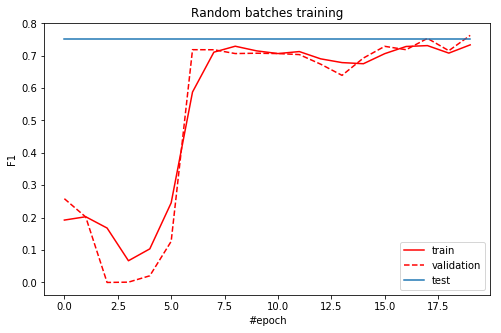

In [8]:
test_f1 = get_f1(model, label_codes, test_encoded_symbols, test_encoded_tokens,
                 test_encoded_labels, unique_labels_count)

print(test_f1)

plt.figure(figsize=(8, 5))
plt.plot([x['train'] for x in rb_epoch_f1s], 'r', label='train')
plt.plot([x['val'] for x in rb_epoch_f1s], 'r--', label='validation')
plt.plot(np.ones(len(rb_epoch_f1s))*test_f1, label='test')
plt.title('Random batches training')
plt.ylabel('F1')
plt.xlabel('#epoch')
plt.legend()
plt.show()

In [9]:
token_embeddings_tensor = build_token_embeddings_tensor(token_codes, word2vec, 300)

model = NERTagger(unique_symbols_count, unique_labels_count, token_dimension,
                  token_embeddings_tensor)

loss_function = nn.NLLLoss(torch.Tensor(nllloss_weights))
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
def get_indices_sorted_by_confidence(model, start_index, encoded_symbols, encoded_tokens,
                                     encoded_labels, token_codes):

    batch_size = 200

    example_confidences = []

    for batch_index in range((len(encoded_symbols) - start_index)//batch_size + 1):

        batch_start = start_index + batch_size*batch_index
        batch_end = min(start_index + batch_size*(batch_index + 1), len(encoded_symbols))

        if batch_start == batch_end:
            break

        batch_encoded_symbols = encoded_symbols[batch_start:batch_end]
        batch_encoded_tokens = encoded_tokens[batch_start:batch_end]
        batch_encoded_labels = encoded_labels[batch_start:batch_end]

        predicted_label_logprobs = model(autograd.Variable(torch.LongTensor(batch_encoded_symbols)),
                                         autograd.Variable(torch.LongTensor(batch_encoded_tokens))\
                                        ).data.numpy()

        for tokens, labels, label_logprobs in zip(batch_encoded_tokens, batch_encoded_labels,
                                                  predicted_label_logprobs):

            #sequence_indices = np.arange(len(label_logprobs))
            #max_label_logprobs = label_logprobs[sen]
            #true_label_logprobs = label_logprobs[sequence_indices, labels]
            #example_confidences.append(true_label_logprobs.mean())
            example_confidences.append(label_logprobs.max(axis=1).mean())

    example_confidences = np.array(example_confidences)

    return example_confidences.argsort() + start_index

def get_indices_sorted_by_dropout_disagreement(model, start_index, encoded_symbols,
                                               encoded_tokens, encoded_labels, token_codes):

    model.train(mode=True)

    batch_size = 200
    samples_count = 10

    example_disagreements = []

    for batch_index in range((len(encoded_symbols) - start_index)//batch_size + 1):

        batch_start = start_index + batch_size*batch_index
        batch_end = min(start_index + batch_size*(batch_index + 1), len(encoded_symbols))

        if batch_start == batch_end:
            break

        batch_encoded_symbols = encoded_symbols[batch_start:batch_end]
        batch_encoded_tokens = encoded_tokens[batch_start:batch_end]
        batch_encoded_labels = encoded_labels[batch_start:batch_end]

        predicted_label_samples = []

        for sample_index in range(samples_count):
            predicted_labels = model(autograd.Variable(torch.LongTensor(batch_encoded_symbols)),
                                     autograd.Variable(torch.LongTensor(batch_encoded_tokens))\
                                    ).data.numpy().argmax(axis=2)
            predicted_label_samples.append(predicted_labels)

        predicted_label_samples = np.array(predicted_label_samples).transpose(1, 2, 0)

        batch_token_scores = (predicted_label_samples == predicted_label_samples.max(axis=2)[:, :, np.newaxis]\
                             ).sum(axis=2)

        for tokens, labels, token_scores in zip(batch_encoded_tokens, batch_encoded_labels,
                                                batch_token_scores):

            example_disagreements.append(token_scores.mean())

    example_disagreements = np.array(example_disagreements)

    return example_disagreements.argsort() + start_index

In [11]:
# ACTIVE LEARNING - LEAST CONFIDENCE

epochs_count = 20
batch_size = 200
al_batch_size = 100
al_passes_count = 1
EPSILON = 1e-10

al_train_encoded_symbols = np.array(train_encoded_symbols)
al_train_encoded_tokens = np.array(train_encoded_tokens)
al_train_encoded_labels = np.array(train_encoded_labels)

al_train_data_size = 500

starting_timestamp = datetime.datetime.now()

lc_epoch_f1s = []
lc_epoch_seconds = []

for epoch in range(epochs_count):

    data_pass_f1 = {}
    data_pass_f1['train'] = 0.0

    model.train(mode=True)

    for pass_index in range(al_passes_count):

        train_data_permutation = np.random.permutation(al_train_data_size)

        for i in range(al_train_data_size//al_batch_size):

            model.zero_grad()

            batch_indices = train_data_permutation[al_batch_size*i:al_batch_size*(i + 1)]

            batch_encoded_symbols = autograd.Variable(torch.LongTensor(
                    al_train_encoded_symbols[batch_indices]))

            batch_encoded_tokens = al_train_encoded_tokens[batch_indices]
            random_mask = np.random.uniform(size=batch_encoded_tokens.shape)
            batch_encoded_tokens[random_mask > 0.5] = token_codes['__unknown__']
            batch_encoded_tokens = autograd.Variable(torch.LongTensor(
                    batch_encoded_tokens))

            batch_encoded_labels_numpy = al_train_encoded_labels[batch_indices]
            batch_labels_count = batch_encoded_labels_numpy.shape[0]*\
                    batch_encoded_labels_numpy.shape[1]
            batch_encoded_labels_numpy = batch_encoded_labels_numpy.ravel()
            batch_encoded_labels = autograd.Variable(torch.LongTensor(
                    batch_encoded_labels_numpy))

            predicted_label_probs = model(batch_encoded_symbols, batch_encoded_tokens).view(
                    batch_labels_count, unique_labels_count)

            predicted_encoded_labels = predicted_label_probs.data.numpy().argmax(axis=1)

            relevant_mask = (batch_encoded_labels_numpy != label_codes['none'])
            selected_mask = (predicted_encoded_labels != label_codes['none'])
            relevant_and_selected_count = np.logical_and(relevant_mask, selected_mask).sum()

            recall = relevant_and_selected_count/(relevant_mask.sum() + EPSILON)
            precision = relevant_and_selected_count/(selected_mask.sum() + EPSILON)
            f1 = 2*recall*precision/(recall + precision + EPSILON)

            data_pass_f1['train'] += f1

            loss = loss_function(predicted_label_probs, batch_encoded_labels)
            loss.backward()
            optimizer.step()

    data_pass_f1['train'] /= (al_train_data_size//al_batch_size)*al_passes_count

    model.train(mode=False)

    data_pass_f1['val'] = get_f1(model, label_codes, val_encoded_symbols,
                                 val_encoded_tokens, val_encoded_labels,
                                 unique_labels_count)

    print('#{} train examples:'.format(al_train_data_size))
    print('\ttrain_f1={0:.3f} val_f1={1:.3f}'.format(data_pass_f1['train'],
                                                     data_pass_f1['val']))

    lc_epoch_f1s.append(data_pass_f1)
    lc_epoch_seconds.append((datetime.datetime.now() - starting_timestamp).total_seconds())

    sorted_indices = get_indices_sorted_by_confidence(model,
            al_train_data_size, al_train_encoded_symbols, al_train_encoded_tokens,
            al_train_encoded_labels, token_codes)

    sorted_indices = np.concatenate((np.arange(al_train_data_size), sorted_indices))

    al_train_encoded_symbols[:, :] = al_train_encoded_symbols[sorted_indices]
    al_train_encoded_tokens[:, :] = al_train_encoded_tokens[sorted_indices]
    al_train_encoded_labels[:, :] = al_train_encoded_labels[sorted_indices]

    al_train_data_size += al_batch_size

#500 train examples:
	train_f1=0.153 val_f1=0.250
#600 train examples:
	train_f1=0.233 val_f1=0.243
#700 train examples:
	train_f1=0.243 val_f1=0.212
#800 train examples:
	train_f1=0.259 val_f1=0.022
#900 train examples:
	train_f1=0.333 val_f1=0.016
#1000 train examples:
	train_f1=0.418 val_f1=0.186
#1100 train examples:
	train_f1=0.465 val_f1=0.356
#1200 train examples:
	train_f1=0.537 val_f1=0.601
#1300 train examples:
	train_f1=0.614 val_f1=0.671
#1400 train examples:
	train_f1=0.690 val_f1=0.724
#1500 train examples:
	train_f1=0.737 val_f1=0.749
#1600 train examples:
	train_f1=0.739 val_f1=0.734
#1700 train examples:
	train_f1=0.736 val_f1=0.773
#1800 train examples:
	train_f1=0.746 val_f1=0.736
#1900 train examples:
	train_f1=0.755 val_f1=0.759
#2000 train examples:
	train_f1=0.768 val_f1=0.780
#2100 train examples:
	train_f1=0.768 val_f1=0.786
#2200 train examples:
	train_f1=0.762 val_f1=0.766
#2300 train examples:
	train_f1=0.759 val_f1=0.730
#2400 train examples:
	train_f1=0.75

0.756744598228


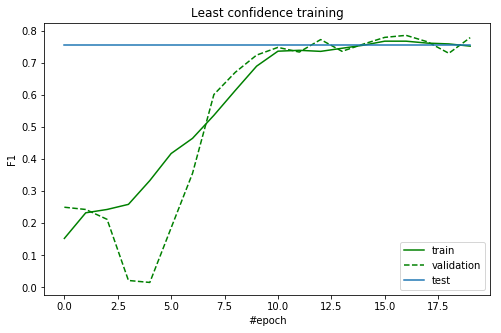

In [12]:
test_f1 = get_f1(model, label_codes, test_encoded_symbols, test_encoded_tokens,
                 test_encoded_labels, unique_labels_count)

print(test_f1)

plt.figure(figsize=(8, 5))
plt.plot([x['train'] for x in lc_epoch_f1s], 'g', label='train')
plt.plot([x['val'] for x in lc_epoch_f1s], 'g--', label='validation')
plt.plot(np.ones(len(lc_epoch_f1s))*test_f1, label='test')
plt.title('Least confidence training')
plt.ylabel('F1')
plt.xlabel('#epoch')
plt.legend()
plt.show()

In [13]:
token_embeddings_tensor = build_token_embeddings_tensor(token_codes, word2vec, 300)

model = NERTagger(unique_symbols_count, unique_labels_count, token_dimension,
                  token_embeddings_tensor)

loss_function = nn.NLLLoss(torch.Tensor(nllloss_weights))
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
# ACTIVE LEARNING - BAYESIAN ACTIVE LEARNING BY DISAGREEMENT

epochs_count = 20
batch_size = 200
al_batch_size = 100
al_passes_count = 1
EPSILON = 1e-10

al_train_encoded_symbols = np.array(train_encoded_symbols)
al_train_encoded_tokens = np.array(train_encoded_tokens)
al_train_encoded_labels = np.array(train_encoded_labels)

al_train_data_size = 500

starting_timestamp = datetime.datetime.now()

bald_epoch_f1s = []
bald_epoch_seconds = []

for epoch in range(epochs_count):

    data_pass_f1 = {}
    data_pass_f1['train'] = 0.0

    model.train(mode=True)

    for pass_index in range(al_passes_count):

        train_data_permutation = np.random.permutation(al_train_data_size)

        for i in range(al_train_data_size//al_batch_size):

            model.zero_grad()

            batch_indices = train_data_permutation[al_batch_size*i:al_batch_size*(i + 1)]

            batch_encoded_symbols = autograd.Variable(torch.LongTensor(
                    al_train_encoded_symbols[batch_indices]))

            batch_encoded_tokens = al_train_encoded_tokens[batch_indices]
            random_mask = np.random.uniform(size=batch_encoded_tokens.shape)
            batch_encoded_tokens[random_mask > 0.5] = token_codes['__unknown__']
            batch_encoded_tokens = autograd.Variable(torch.LongTensor(
                    batch_encoded_tokens))

            batch_encoded_labels_numpy = al_train_encoded_labels[batch_indices]
            batch_labels_count = batch_encoded_labels_numpy.shape[0]*\
                    batch_encoded_labels_numpy.shape[1]
            batch_encoded_labels_numpy = batch_encoded_labels_numpy.ravel()
            batch_encoded_labels = autograd.Variable(torch.LongTensor(
                    batch_encoded_labels_numpy))

            predicted_label_probs = model(batch_encoded_symbols, batch_encoded_tokens).view(
                    batch_labels_count, unique_labels_count)

            predicted_encoded_labels = predicted_label_probs.data.numpy().argmax(axis=1)

            relevant_mask = (batch_encoded_labels_numpy != label_codes['none'])
            selected_mask = (predicted_encoded_labels != label_codes['none'])
            relevant_and_selected_count = np.logical_and(relevant_mask, selected_mask).sum()

            recall = relevant_and_selected_count/(relevant_mask.sum() + EPSILON)
            precision = relevant_and_selected_count/(selected_mask.sum() + EPSILON)
            f1 = 2*recall*precision/(recall + precision + EPSILON)

            data_pass_f1['train'] += f1

            loss = loss_function(predicted_label_probs, batch_encoded_labels)
            loss.backward()
            optimizer.step()

    data_pass_f1['train'] /= (al_train_data_size//al_batch_size)*al_passes_count

    model.train(mode=False)

    data_pass_f1['val'] = get_f1(model, label_codes, val_encoded_symbols,
                                 val_encoded_tokens, val_encoded_labels,
                                 unique_labels_count)

    print('#{} train examples:'.format(al_train_data_size))
    print('\ttrain_f1={0:.3f} val_f1={1:.3f}'.format(data_pass_f1['train'],
                                                     data_pass_f1['val']))

    bald_epoch_f1s.append(data_pass_f1)
    bald_epoch_seconds.append((datetime.datetime.now() - starting_timestamp).total_seconds())

    sorted_indices = get_indices_sorted_by_dropout_disagreement(model,
            al_train_data_size, al_train_encoded_symbols, al_train_encoded_tokens,
            al_train_encoded_labels, token_codes)

    sorted_indices = np.concatenate((np.arange(al_train_data_size), sorted_indices))

    al_train_encoded_symbols[:, :] = al_train_encoded_symbols[sorted_indices]
    al_train_encoded_tokens[:, :] = al_train_encoded_tokens[sorted_indices]
    al_train_encoded_labels[:, :] = al_train_encoded_labels[sorted_indices]

    al_train_data_size += al_batch_size

#500 train examples:
	train_f1=0.158 val_f1=0.064
#600 train examples:
	train_f1=0.234 val_f1=0.254
#700 train examples:
	train_f1=0.231 val_f1=0.261
#800 train examples:
	train_f1=0.231 val_f1=0.262
#900 train examples:
	train_f1=0.241 val_f1=0.206
#1000 train examples:
	train_f1=0.260 val_f1=0.032
#1100 train examples:
	train_f1=0.157 val_f1=0.017
#1200 train examples:
	train_f1=0.122 val_f1=0.110
#1300 train examples:
	train_f1=0.243 val_f1=0.218
#1400 train examples:
	train_f1=0.471 val_f1=0.288
#1500 train examples:
	train_f1=0.645 val_f1=0.500
#1600 train examples:
	train_f1=0.710 val_f1=0.350
#1700 train examples:
	train_f1=0.741 val_f1=0.437
#1800 train examples:
	train_f1=0.750 val_f1=0.350
#1900 train examples:
	train_f1=0.746 val_f1=0.305
#2000 train examples:
	train_f1=0.756 val_f1=0.449
#2100 train examples:
	train_f1=0.760 val_f1=0.345
#2200 train examples:
	train_f1=0.765 val_f1=0.532
#2300 train examples:
	train_f1=0.754 val_f1=0.434
#2400 train examples:
	train_f1=0.75

0.330857425664


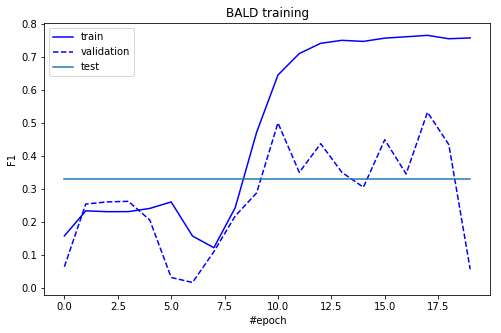

In [15]:
test_f1 = get_f1(model, label_codes, test_encoded_symbols, test_encoded_tokens,
                 test_encoded_labels, unique_labels_count)

print(test_f1)

plt.figure(figsize=(8, 5))
plt.plot([x['train'] for x in bald_epoch_f1s], 'b', label='train')
plt.plot([x['val'] for x in bald_epoch_f1s], 'b--', label='validation')
plt.plot(np.ones(len(bald_epoch_f1s))*test_f1, label='test')
plt.title('BALD training')
plt.ylabel('F1')
plt.xlabel('#epoch')
plt.legend()
plt.show()

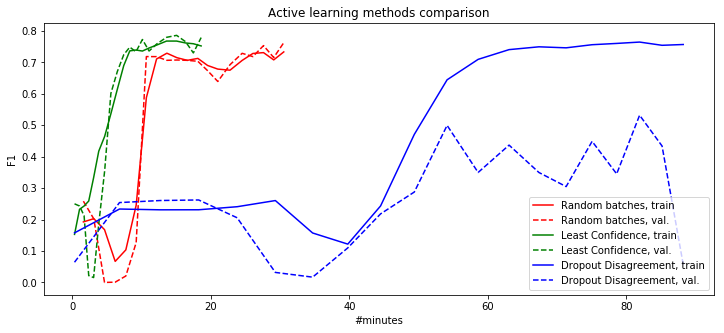

In [16]:
plt.figure(figsize=(12, 5))

for color, method_name, epoch_f1s, epoch_seconds in [('r', 'Random batches', rb_epoch_f1s, rb_epoch_seconds),
                                                     ('g', 'Least Confidence', lc_epoch_f1s, lc_epoch_seconds),
                                                     ('b', 'Dropout Disagreement', bald_epoch_f1s,
                                                      bald_epoch_seconds)]:

    epoch_minutes = [x/60.0 for x in epoch_seconds]
    
    plt.plot(epoch_minutes, [x['train'] for x in epoch_f1s], color, label='{}, train'.format(method_name))
    plt.plot(epoch_minutes, [x['val'] for x in epoch_f1s], color + '--', label='{}, val.'.format(method_name))

plt.title('Active learning methods comparison')
plt.xlabel('#minutes')
plt.ylabel('F1')
plt.legend()
plt.show()